In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras_tuner import RandomSearch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

In [ ]:

df = pd.read_csv("/content/stock_market_data-DAL.csv")
# Display the DataFrame
print(df.head())

         Date    Low   High  Close   Open
0  03-05-2007  20.55  21.95  20.72  21.75
1  04-05-2007  20.70  21.35  20.98  21.05
2  07-05-2007  20.20  21.29  20.36  21.20
3  08-05-2007  19.30  20.00  19.63  20.00
4  09-05-2007  19.63  20.20  19.79  19.75


In [ ]:
def get_stock_data_with_normalization(df):
    # Perform normalization
    scaler = MinMaxScaler(feature_range=(0, 1))
    df_scaled = df.copy()
    df_scaled[['Open', 'High', 'Low', 'Close']] = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close']])
    return df_scaled, scaler

# Preprocess the data
df, scaler = get_stock_data_with_normalization(df)

In [ ]:
X = df[['Open', 'High', 'Low']]
Y = df[['Close']]

# Split data into training and testing sets (shuffle=False to maintain the temporal order)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
def create_model(hp):
    model = Sequential()

    # Randomly choose the number of neurons for each layer
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=128, step=32), activation='relu', input_dim=3))

    # Add a second layer with random units
    model.add(Dense(units=hp.Int('units_2', min_value=16, max_value=64, step=16), activation='relu'))

    # Add output layer
    model.add(Dense(units=1, activation='linear'))

    # Compile the model
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='mean_squared_error')

    return model

# Create the Keras Tuner random search object
tuner = RandomSearch(
    create_model,
    objective='val_loss',
    max_trials=5,  # You can increase this for better results
    executions_per_trial=3,  # Number of trials to run for each configuration
    directory='/content/kerastuner',
    project_name='stock_price_prediction'
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Trial 5 Complete [00h 00m 52s]
val_loss: 6.715262861689553e-05

Best val_loss So Far: 6.715262861689553e-05
Total elapsed time: 00h 04m 23s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1268e-04 - val_loss: 6.6948e-05
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0802e-05 - val_loss: 7.2126e-05
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1670e-05 - val_loss: 7.4153e-05
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1864e-05 - val_loss: 7.0904e-05
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.5181e-05 - val_loss: 7.0828e-05
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4539e-05 - val_loss: 9.7934e-05
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7479e-05 - val_loss: 6.9434e-05
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2403e-05 - val_loss: 6.6158e-05
Epoch 9/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3753e-05 - val_loss: 6.6225e-05
Epoch 10/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3329e-05 - val_loss: 7.4031e-05
Epoch 11/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss

In [ ]:
predictions = best_model.predict(X_test)

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [ ]:
Y_test_actual = scaler.inverse_transform(np.hstack([X_test, Y_test]))[:, -1]
predictions_actual = scaler.inverse_transform(np.hstack([X_test, predictions]))[:, -1]

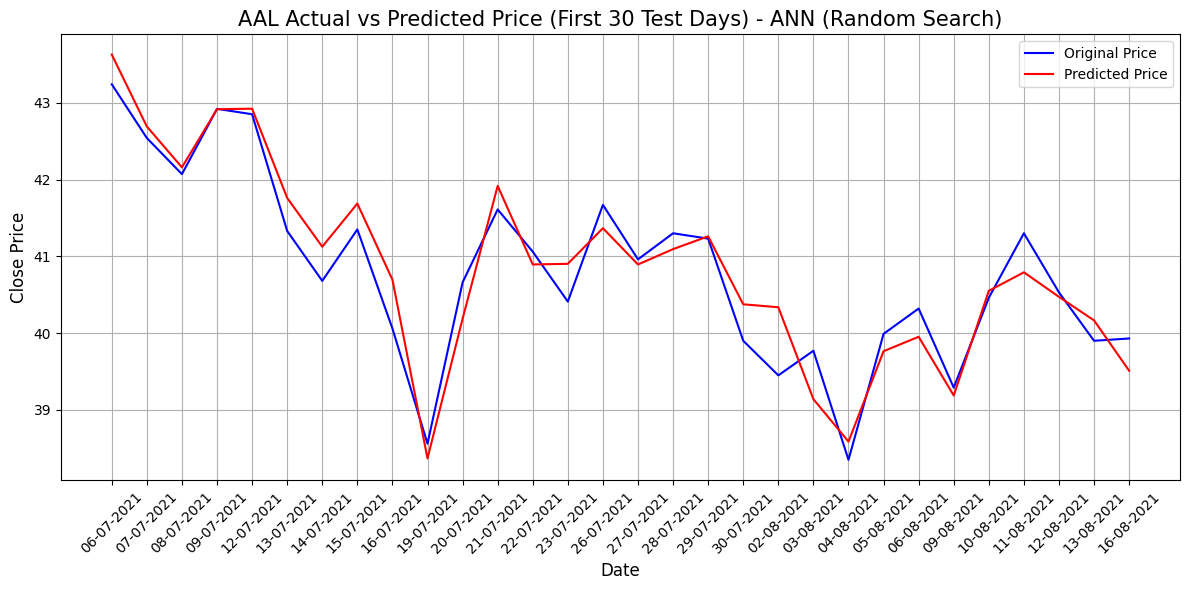

In [ ]:
# Assuming 'df' has a 'Date' column
# Extract the test dates
test_dates = df['Date'].iloc[-len(X_test):].reset_index(drop=True)

# Get the first 30 test dates
first_30_dates = test_dates[:30]

plt.figure(figsize=(12, 6))
plt.plot(first_30_dates, Y_test_actual[:30], label="Original Price", color='b')
plt.plot(first_30_dates, predictions_actual[:30], label="Predicted Price", color='r')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.title("AAL Actual vs Predicted Price (First 30 Test Days) - ANN (Random Search)", fontsize=15)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


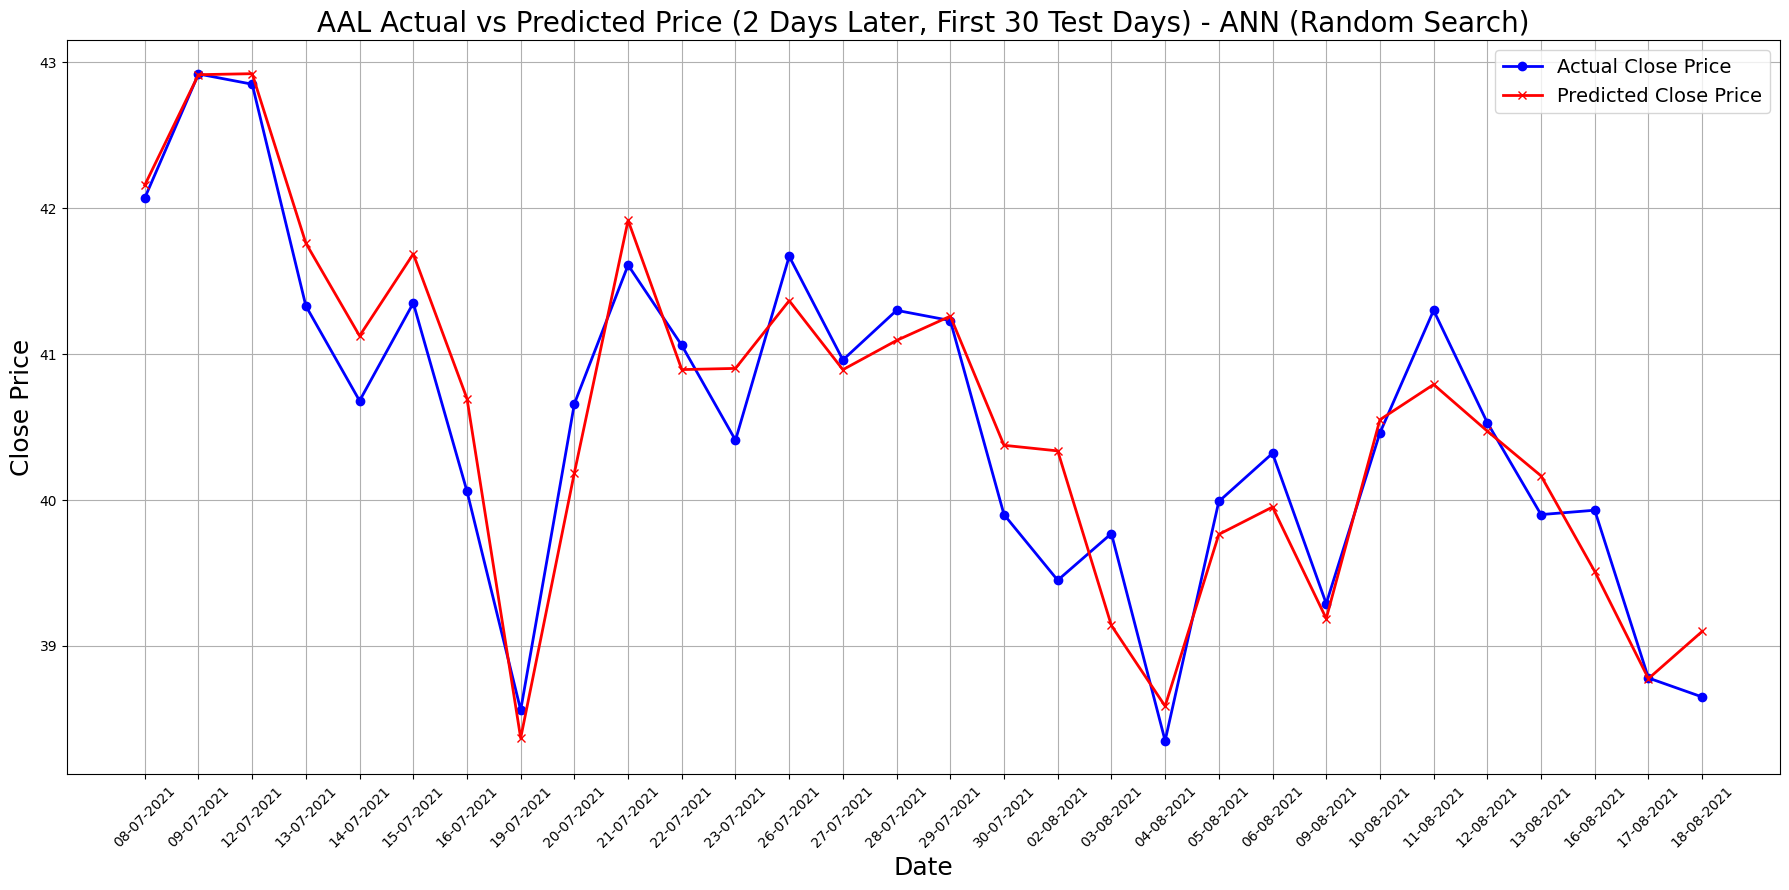

Plot saved as 'ann dal.png'


In [ ]:
# Assuming 'df' has a 'Date' column
# Extract the test dates
test_dates = df['Date'].iloc[-len(X_test):].reset_index(drop=True)

# Adjust to start 2 days later and get the next 30 dates
first_30_dates_adjusted = test_dates[2:32]  # Start 2 days after and take the next 30 dates

# Create the plot with a larger size (18, 9)
plt.figure(figsize=(18, 9))

# Plot the actual close price with marker 'o'
plt.plot(
    first_30_dates_adjusted,
    Y_test_actual[2:32],
    label="Actual Close Price",
    color='b',
    marker='o',
    linewidth=2,
    markersize=6
)

# Plot the predicted close price with marker 'x'
plt.plot(
    first_30_dates_adjusted,
    predictions_actual[2:32],
    label="Predicted Close Price",
    color='r',
    marker='x',
    linewidth=2,
    markersize=6
)

# Formatting
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.title("AAL Actual vs Predicted Price (2 Days Later, First 30 Test Days) - ANN (Random Search)", fontsize=20)
plt.xticks(rotation=45)  # Rotate dates for better visibility
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()

# Save the plot as a downloadable image
file_name = "ann dal.png"
plt.savefig(file_name, dpi=300)  # Save as high-resolution image
plt.show()

# Confirmation of the saved file
print(f"Plot saved as '{file_name}'")


In [ ]:
plt.savefig("linear_reg_first_30_test_days_shifted_plot.png", dpi=300)  # Optional: Save the plot
plt.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
mse = mean_squared_error(Y_test_actual, predictions_actual)
rmse = math.sqrt(mse)
mae = mean_absolute_error(Y_test_actual, predictions_actual)
r2 = r2_score(Y_test_actual, predictions_actual)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 0.13821534883346673
Root Mean Squared Error (RMSE): 0.371773249217136
Mean Absolute Error (MAE): 0.28672781362946087
R-squared (R2): 0.9978152796167176
